The notebook is a little messy but the core logic is present. Start from the "load data" section for indexing.

In [476]:
import streamlit as st
api_key = st.secrets["openai_key"]

# check changes in files
(we only want to load and process new files)

In [478]:
import os
import hashlib
import pickle

In [540]:
def display_file_structure(root_folder, indent_level=0, ignore_folders=None):
    if ignore_folders is None:
        ignore_folders = []
    
    try:
        for item in os.listdir(root_folder):
            item_path = os.path.join(root_folder, item)
            # Check if the item is a folder to be ignored
            if os.path.isdir(item_path) and item in ignore_folders:
                continue
            
            if os.path.isdir(item_path):
                print('    ' * indent_level + f'📁 {item}')
                display_file_structure(item_path, indent_level + 1, ignore_folders)
            else:
                print('    ' * indent_level + f'📄 {item}')
    except PermissionError:
        print('    ' * indent_level + '⚠️ [Access Denied]')

# Example usage
root_folder_path = './documents'
ignore_folders = ['temp']
display_file_structure(root_folder_path, ignore_folders=ignore_folders)

📁 General
    📄 Pictures.pdf
    📄 resume.pdf
    📄 Supplementary info for Josh Jingtian Wang.pdf
📁 IFF
    📄 final presentation.pptx
    📄 iff-model-compare usage.pdf
    📄 internship_report.pdf
    📄 ModelCompare.pdf
    📄 model_compare.py
    📄 power_simulation.py
📁 Roblox
    📄 Josh DSA All Hands Lightning Round.pptx
    📄 Josh Wang Final Presentation DSA.pptx
    📄 Josh Wang Internship at Roblox Report.pdf
    📄 Project 1_ SliceFinder Final Writeup.pdf
    📄 SliceFinder (BYOL Presentation).pptx
📁 UC Irvine
    📄 JW_Dissertation_20220824.pdf
📁 University of Rochester
    📄 computational intro to stats final project report.pdf
    📄 data mining Final Project (Report).pdf
    📄 deep learning project report.pdf
    📄 GAN_capstone_project_presentation.pptx
    📄 GAN_capstone_project_report.pdf
    📄 kaggle_election_donation_project_report.pptx
    📄 kaggle_northern_europe_politician_tweet_project_report.pdf
    📄 kaggle_ohio_covid_project_report.pdf


## load previous file structure

In [541]:
def get_file_structure_with_checksums(root_dir, ignore_subfolder):
    file_structure = {}
    ignore_path = os.path.normpath(os.path.join(root_dir, ignore_subfolder))

    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Skip the ignored subfolder
        if os.path.commonpath([dirpath, ignore_path]) == ignore_path:
            continue

        # Normalize the directory path and store the file list with checksums
        relative_dirpath = os.path.relpath(dirpath, root_dir)
        file_structure[relative_dirpath] = {f: generate_checksum(os.path.join(dirpath, f)) for f in filenames}
    
    return file_structure

def generate_checksum(file_path):
    sha256 = hashlib.sha256()
    try:
        with open(file_path, 'rb') as f:
            while chunk := f.read(8192):
                sha256.update(chunk)
    except IOError:
        return None
    return sha256.hexdigest()

def load_file_structure(pickle_file):
    with open(pickle_file, 'rb') as f:
        return pickle.load(f)

def compare_file_structures(old_structure, new_structure):
    changes = {'added': [], 'removed': [], 'modified': []}
    
    all_paths = set(old_structure.keys()).union(set(new_structure.keys()))
    
    for dirpath in all_paths:
        old_files = old_structure.get(dirpath, {})
        new_files = new_structure.get(dirpath, {})
        
        # Files added
        for file in new_files.keys() - old_files.keys():
            changes['added'].append(os.path.join(dirpath, file))
        
        # Files removed
        for file in old_files.keys() - new_files.keys():
            changes['removed'].append(os.path.join(dirpath, file))
        
        # Files modified
        for file in old_files.keys() & new_files.keys():
            if old_files[file] != new_files[file]:
                changes['modified'].append(os.path.join(dirpath, file))
    
    return changes

def print_changes(changes):
    for change_type, files in changes.items():
        print(f"\n{change_type.capitalize()} files:")
        if files:
            for file in files:
                print(f"  - {file}")
        else:
            print("  None")

In [542]:
root_dir = './documents'
pickle_file = 'file_structure_with_checksums.pkl'
ignore_subfolder = 'temp'

current_file_structure = get_file_structure_with_checksums(root_dir, ignore_subfolder)
saved_file_structure = load_file_structure(pickle_file)
changes = compare_file_structures(saved_file_structure, current_file_structure)

# Print changes in a readable format
print_changes(changes)


Added files:
  - General/resume.pdf
  - General/Pictures.pdf

Removed files:
  - General/JingtianWang_Resume_20240627.pdf

Modified files:
  - General/Supplementary info for Josh Jingtian Wang.pdf


In [543]:
changes

{'added': ['General/resume.pdf', 'General/Pictures.pdf'],
 'removed': ['General/JingtianWang_Resume_20240627.pdf'],
 'modified': ['General/Supplementary info for Josh Jingtian Wang.pdf']}

## save current file structure

In [544]:
def save_file_structure(root_dir, pickle_file, ignore_subfolder):
    file_structure = get_file_structure_with_checksums(root_dir, ignore_subfolder)
    with open(pickle_file, 'wb') as f:
        pickle.dump(file_structure, f)

In [545]:
root_dir = './documents'
pickle_file = 'file_structure_with_checksums.pkl'
ignore_subfolder = 'temp'
save_file_structure(root_dir, pickle_file, ignore_subfolder)

# load data

## whole document summaries

In [546]:
from langchain.chains.summarize import load_summarize_chain
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import UnstructuredFileLoader
from tqdm import tqdm
from langchain_core.documents import Document

In [547]:
# # Load all files in the documents folder
# def load_files(root_folder, exclude_folders):
#     all_data = []
#     for foldername, subfolders, filenames in os.walk(root_folder):
#         # Skip excluded folders
#         if any(excluded in foldername for excluded in exclude_folders):
#             continue

#         for filename in filenames:
#             file_path = os.path.join(foldername, filename)
#             try:
#                 loader = UnstructuredFileLoader(file_path, mode="single")
#                 data = loader.load()
#                 all_data.extend(data)
#                 print(f'Loaded {file_path}')
#             except Exception as e:
#                 print(f'Failed to load {file_path}: {e}')
    
#     return all_data

def load_added_files(root_folder, changes):
    all_data = []
    added_files = changes.get('added', [])
    modified_files = changes.get('modified', [])
    files_to_load = added_files + modified_files
    
    for file_path in files_to_load:
        
        file_name_with_ext = os.path.basename(file_path)
        file_name, file_extension = os.path.splitext(file_name_with_ext)
        if file_name.lower() == 'pictures':
            print(f'Skipping {file_path} because it is a picture file')
            continue
        
        full_path = os.path.join(root_folder, file_path)
        
        try:
            loader = UnstructuredFileLoader(full_path, mode="single")
            data = loader.load()
            all_data.extend(data)
            print(f'Loaded {full_path}')
        except Exception as e:
            print(f'Failed to load {full_path}: {e}')
    
    return all_data

In [548]:
# Define the root folder and folders to exclude
root_folder_path = './documents'  # Replace with your actual path
#exclude_folders = ['test']

# Load the files and store the result in a list
loaded_data = load_added_files(root_dir, changes)

Loaded ./documents/General/resume.pdf
Skipping General/Pictures.pdf because it is a picture file
Loaded ./documents/General/Supplementary info for Josh Jingtian Wang.pdf


In [549]:
llm = ChatOpenAI(temperature=0, model='gpt-3.5-turbo', openai_api_key=api_key)

In [550]:
ultra_long_docs = []
filtered_loaded_data = []

# Iterate through loaded_data and categorize documents based on token count
for doc in loaded_data:
    num_tokens = llm.get_num_tokens(doc.page_content)
    if num_tokens > 20000:
        ultra_long_docs.append(doc)
    else:
        filtered_loaded_data.append(doc)

# Assign the filtered list back to loaded_data
loaded_data = filtered_loaded_data

# Optionally, print the results to verify
print(f"Number of ultra long docs: {len(ultra_long_docs)}")
print(f"Number of remaining docs: {len(loaded_data)}")

Number of ultra long docs: 0
Number of remaining docs: 2


In [551]:
combine_prompt_template = """
You will be given a series of summaries from a document.
You are also given the source of the document.
Your goal is to give a verbose summary of the entire document. 
Your final summary should reflect not only the series of summaries but also the source of the document.

Here is an example to guide you:

If the source of a document is './documents/UC Irvine/JW_Dissertation_20220824.pdf', your final summary should mention that this document is a dissertation from UC Irvine. For instance:

Example:

SOURCE:
./documents/UC Irvine/JW_Dissertation_20220824.pdf

VERBOSE SUMMARY:
This document is a dissertation from UC Irvine. It explores the topic of...

Now, use the following summaries and source to create a verbose summary.

SUMMARIES:
{text}

SOURCE:
{source}

VERBOSE SUMMARY:
"""

COMBINE_PROMPT = PromptTemplate.from_template(combine_prompt_template)

In [552]:
whole_doc_summaries = []
for doc in tqdm(filtered_loaded_data):
    num_tokens = llm.get_num_tokens(doc.page_content)
    doc_source = doc.metadata['source']
    if num_tokens > 20000:
        print(f"Document '{doc_source}' has {num_tokens} tokens. It is too long to summarize in one go. Will be processed using Best Representation Vectors")
        continue

    COMBINE_PROMPT_PARTIAL = COMBINE_PROMPT.partial(source=doc_source)
    summarize_chain = load_summarize_chain(llm, chain_type="map_reduce", combine_prompt=COMBINE_PROMPT_PARTIAL)
    summary = summarize_chain.invoke([doc])
    summary_doc = Document(page_content=summary['output_text'], metadata={"source": doc_source})
    whole_doc_summaries.append(summary_doc)

100%|██████████| 2/2 [00:05<00:00,  2.70s/it]


In [553]:
whole_doc_summaries

[Document(page_content="This document is a resume highlighting the professional experience and skills of Dr. Jingtian 'Josh' Wang. Dr. Wang is a Data Scientist with a background in Molecular Biology and Biochemistry from the University of California, Irvine. He has experience in developing advanced chatbots, using generative AI to predict laser output, and winning Kaggle challenges. Dr. Wang has interned at Roblox and IFF, where he improved data analysis tools and implemented machine learning models. His skill set includes Bash, Deep Learning, NLP, Python, and more.", metadata={'source': './documents/General/resume.pdf'}),
 Document(page_content='The document titled "Supplementary info for Josh Jingtian Wang" provides additional information about Josh Jingtian Wang, who is currently residing in Arlington, VA with his wife and cat. It mentions his interests in powerlifting, plant care, and video gaming, as well as his career aspirations in Data Science and Machine Learning Engineering r

### Clustering to summarize ultra long docs
https://github.com/gkamradt/langchain-tutorials/blob/main/data_generation/5%20Levels%20Of%20Summarization%20-%20Novice%20To%20Expert.ipynb

The BRV Steps:

1. Load your book into a single text file
2. Split your text into large-ish chunks
3. Embed your chunks to get vectors
4. Cluster the vectors to see which are similar to each other and likely talk about the same parts of the book
5. Pick embeddings that represent the cluster the most (method: closest to each cluster centroid)
6. Summarize the documents that these embeddings represent

In [88]:
# Loaders
from langchain.schema import Document

# Splitters
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Model
from langchain_openai import ChatOpenAI

# Embedding Support
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

# Summarizer we'll use for Map Reduce
from langchain.chains.summarize import load_summarize_chain

# Data Science
import numpy as np
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Taking out the warnings
import warnings
from warnings import simplefilter
# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

In [51]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", "\t"], chunk_size=10000, chunk_overlap=3000)

docs = text_splitter.split_documents(ultra_long_docs[0])

In [52]:
num_documents = len(docs)

print (f"Now our long doc is split up into {num_documents} documents")

Now our long doc is split up into 35 documents


In [55]:
embeddings = OpenAIEmbeddings(openai_api_key=api_key)

vectors = embeddings.embed_documents([x.page_content for x in docs])

In [97]:
# # Elbow plot

# # Define the range for number of clusters
# cluster_range = range(1, 14)

# # Calculate the inertia for each number of clusters
# inertia = []
# for n_clusters in tqdm(cluster_range):
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     kmeans.fit(vectors)
#     inertia.append(kmeans.inertia_)

# # Plot the elbow plot
# plt.figure(figsize=(8, 6))
# plt.plot(cluster_range, inertia, marker='o')
# plt.title('Elbow Plot for K-means Clustering')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Inertia')
# plt.xticks(cluster_range)
# plt.grid(True)
# plt.show()

In [98]:
# Assuming 'embeddings' is a list or array of 1536-dimensional embeddings

# Choose the number of clusters, this can be adjusted based on the document's content.
# Choosing 8 because the document has 7 chapters and 1 introduction
num_clusters = 8

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)

In [99]:
kmeans.labels_

array([0, 0, 7, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 5, 5, 5, 5, 5, 5, 3, 6,
       4, 4, 6, 6, 6, 4, 4, 1, 1, 1, 1, 1, 7], dtype=int32)

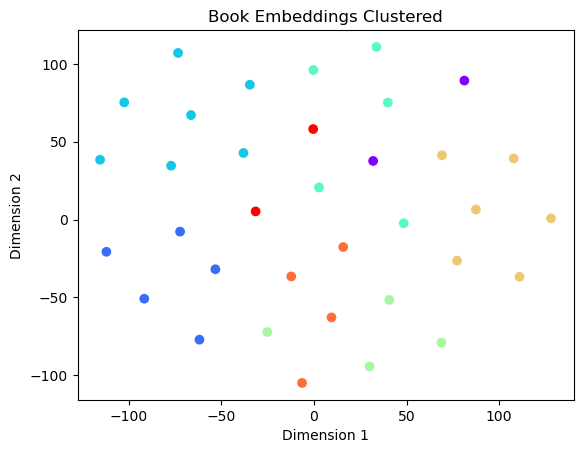

In [100]:
vectors = np.array(vectors)

# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(np.array(vectors))

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_, cmap='rainbow')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Book Embeddings Clustered')
plt.show()

In [101]:
# Find the closest embeddings to the centroids

# Create an empty list that will hold your closest points
closest_indices = []

# Loop through the number of clusters you have
for i in range(num_clusters):
    
    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)
    
    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)
    
    # Append that position to your closest indices list
    closest_indices.append(closest_index)

In [102]:
selected_indices = sorted(closest_indices)
selected_indices

[0, 2, 3, 5, 16, 23, 25, 30]

In [103]:
selected_docs = [docs[doc] for doc in selected_indices]

In [186]:
# summary chain
llm = ChatOpenAI(temperature=0, model='gpt-3.5-turbo', openai_api_key=api_key)

doc_source = loaded_data[3].metadata['source']
COMBINE_PROMPT_PARTIAL = COMBINE_PROMPT.partial(source=doc_source)
summarize_chain = load_summarize_chain(llm, chain_type="map_reduce", combine_prompt=COMBINE_PROMPT_PARTIAL)

In [188]:
dissertation_summary = summarize_chain.invoke(selected_docs)

In [189]:
print(dissertation_summary['output_text'])

This document is a dissertation from the University of California, Irvine, submitted by Jingtian "Josh" Wang for the degree of Doctor of Philosophy in Molecular Biology and Biochemistry. The dissertation focuses on advancements in controlling gene expression in cancer gene therapies. It includes chapters on posttranslational modifications on RNA binding proteins, selective cancer cell killing, Tet-ON inducible gene expression, the role of chromatin remodeling protein HELLS in retinoblastoma, and the identification of regulators of dendrite arborization. The research aims to enhance the specificity and effectiveness of cancer gene therapies by targeting specific biochemical defects in cancer cells. 

Gene therapy trials for cancer treatment have been exploring new approaches to target cancer cells specifically without harming normal tissues. The dissertation discusses the challenges and strategies involved in achieving this goal, including the use of cancer-specific promoters and target

In [344]:
dissertation_source = loaded_data[3].metadata["source"]
dissertation_summary_doc = Document(page_content=dissertation_summary['output_text'], metadata={"source": dissertation_source})

In [346]:
whole_doc_summaries.append(dissertation_summary_doc)

## extract and summarize images

In [554]:
import os
from unstructured.partition.pdf import partition_pdf

In [555]:
# def extract_images(root_folder, exclude_folders):
#     all_raw_pdf_elements = []
#     for foldername, subfolders, filenames in tqdm(os.walk(root_folder)):
#         # Skip excluded folders
#         if any(excluded in foldername for excluded in exclude_folders):
#             continue

#         for filename in filenames:
#             if not filename.lower().endswith('.pdf'):
#                 continue  # Skip non-PDF files
            
#             file_path = os.path.join(foldername, filename)
#             print(f'Loading and processing {file_path}')
#             file_name_without_extension = os.path.splitext(filename)[0]
#             relative_folder_path = os.path.relpath(foldername, root_folder)
#             if relative_folder_path == ".":
#                 output_dir = os.path.join("./extracted_images", file_name_without_extension)
#             else:
#                 output_dir = os.path.join("./extracted_images", relative_folder_path, file_name_without_extension)
#             #print(f'Output dir: {output_dir}')
#             try:
#                 raw_pdf_elements = partition_pdf(
#                     filename=file_path,
#                     extract_images_in_pdf=True,
#                     infer_table_structure=True,
#                     image_output_dir_path=output_dir
#                 )
#                 all_raw_pdf_elements.append(raw_pdf_elements)
#                 print(f'Loaded and processed {file_path}')
#             except Exception as e:
#                 print(f'Failed to load {file_path}: {e}')
    
#     return all_raw_pdf_elements

def extract_images(root_folder, changes):
    all_raw_pdf_elements = []
    added_files = changes.get('added', [])
    modified_files = changes.get('modified', [])
    files_to_load = added_files + modified_files
    
    for file_path in tqdm(files_to_load):
        if not file_path.lower().endswith('.pdf'):
            continue  # Skip non-PDF files

        full_path = os.path.join(root_folder, file_path)
        print(f'Loading and processing {full_path}')
        
        file_name_without_extension = os.path.splitext(os.path.basename(file_path))[0]
        relative_folder_path = os.path.dirname(file_path)
        if relative_folder_path == ".":
            output_dir = os.path.join("./extracted_images", file_name_without_extension)
        else:
            output_dir = os.path.join("./extracted_images", relative_folder_path, file_name_without_extension)

        try:
            raw_pdf_elements = partition_pdf(
                filename=full_path,
                extract_images_in_pdf=True,
                infer_table_structure=True,
                image_output_dir_path=output_dir
            )
            all_raw_pdf_elements.append(raw_pdf_elements)
            print(f'Loaded and processed {full_path}')
        except Exception as e:
            print(f'Failed to load {full_path}: {e}')
    
    return all_raw_pdf_elements

In [556]:
root_folder_path = './documents'  # Replace with your actual path
#exclude_folders = ['test']

all_raw_pdf_elements = extract_images(root_folder_path, changes)

  0%|          | 0/3 [00:00<?, ?it/s]

Loading and processing ./documents/General/resume.pdf


 33%|███▎      | 1/3 [00:03<00:07,  3.91s/it]

Loaded and processed ./documents/General/resume.pdf
Loading and processing ./documents/General/Pictures.pdf


 67%|██████▋   | 2/3 [00:34<00:19, 19.57s/it]

Loaded and processed ./documents/General/Pictures.pdf
Loading and processing ./documents/General/Supplementary info for Josh Jingtian Wang.pdf


100%|██████████| 3/3 [00:36<00:00, 12.19s/it]

Loaded and processed ./documents/General/Supplementary info for Josh Jingtian Wang.pdf


## summarize images

In [557]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain.docstore.document import Document
from PIL import Image
import base64
import io
import unstructured

In [558]:
# Function to convert image to base64
def image_to_base64(image_path):
    with Image.open(image_path) as image:
        buffered = io.BytesIO()
        image.save(buffered, format=image.format)
        img_str = base64.b64encode(buffered.getvalue())
        return img_str.decode('utf-8')

In [559]:
# llm = ChatOpenAI(model="gpt-4-vision-preview", openai_api_key = api_key)
llm4o = ChatOpenAI(model="gpt-4o", openai_api_key = api_key)

In [560]:
HUMAN_MESSAGE_TEMPLATE = [
                    {"type": "text", "text" : """
                     Please give a summary of the image provided. Consider the image caption if provided. Be descriptive.
                     
                     Image Caption: {caption}
                     
                     Summary:
                     """},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": "data:image/jpeg;base64,{image_str}"
                        },
                    },
                ]

IMAGE_SUMMARY_PROMPT = ChatPromptTemplate.from_messages(
    [("user", HUMAN_MESSAGE_TEMPLATE)]
)

In [561]:
# def get_llm_response(image_str, caption):
#     msg = llm.invoke(
#         [
#             HumanMessage(
#                 content=[
#                     {"type": "text", "text" : f"""
#                      Please give a summary of the image provided. Consider the image caption if provided. Be descriptive.
                     
#                      Image Caption: {caption}
                     
#                      Summary:
#                      """},
#                     {
#                         "type": "image_url",
#                         "image_url": {
#                             "url": f"data:image/jpeg;base64,{image_str}"
#                         },
#                     },
#                 ]
#             )
#         ]
#     )
#     return msg

image_summary_chain = IMAGE_SUMMARY_PROMPT | llm4o | StrOutputParser()

def get_summary(element, caption = None):
    image_path = element.to_dict()['metadata']["image_path"]
    image_str = image_to_base64(image_path)
    llm_input = {
        "caption": caption,
        "image_str": image_str
    }
    msg = image_summary_chain.invoke(llm_input)
    return msg

def get_metadata(element):
    file_directory = element.to_dict()['metadata']["file_directory"]
    filename = element.to_dict()['metadata']["filename"]
    source = f"{file_directory}/{filename}"
    image_path = element.to_dict()['metadata']["image_path"]
    metadata = {'source': source, 'image_path': image_path}
    return metadata

def process_image_elements(flat_elements):
    image_summaries = []
    
    for i in tqdm(range(len(flat_elements))):
        if isinstance(flat_elements[i], unstructured.documents.elements.Image):
            print('Processing Image')
            print('Getting Summary')
            
            # Check if there is a caption
            if i + 1 < len(flat_elements) and isinstance(flat_elements[i+1], unstructured.documents.elements.FigureCaption):
                caption = flat_elements[i+1].text
            else:
                caption = None
            
            summary = get_summary(flat_elements[i], caption)
            print('Summary:', summary[:20])
            
            metadata = get_metadata(flat_elements[i])
            
            doc = Document(
                page_content=summary,
                metadata=metadata
            )
            
            image_summaries.append(doc)
            
            print('-' * 20)
    
    return image_summaries

In [562]:
flat_elements = [element for sublist in all_raw_pdf_elements for element in sublist]
image_summaries = process_image_elements(flat_elements)

  0%|          | 0/97 [00:00<?, ?it/s]

Processing Image
Getting Summary


 39%|███▉      | 38/97 [00:04<00:07,  8.32it/s]

Summary: The image shows a fl
--------------------
Processing Image
Getting Summary


 41%|████      | 40/97 [00:26<00:49,  1.14it/s]

Summary: The image features a
--------------------
Processing Image
Getting Summary


 43%|████▎     | 42/97 [00:30<00:55,  1.00s/it]

Summary: The image depicts a 
--------------------
Processing Image
Getting Summary


 45%|████▌     | 44/97 [00:34<00:56,  1.07s/it]

Summary: The image shows a fl
--------------------
Processing Image
Getting Summary


 47%|████▋     | 46/97 [00:38<01:00,  1.19s/it]

Summary: The image shows a fl
--------------------
Processing Image
Getting Summary


 49%|████▉     | 48/97 [00:41<01:03,  1.30s/it]

Summary: The image depicts a 
--------------------
Processing Image
Getting Summary


 52%|█████▏    | 50/97 [00:45<01:08,  1.45s/it]

Summary: The image depicts a 
--------------------
Processing Image
Getting Summary


 54%|█████▎    | 52/97 [00:50<01:13,  1.64s/it]

Summary: The image shows a cl
--------------------
Processing Image
Getting Summary


 56%|█████▌    | 54/97 [00:54<01:15,  1.75s/it]

Summary: The image features a
--------------------
Processing Image
Getting Summary


 58%|█████▊    | 56/97 [00:58<01:10,  1.73s/it]

Summary: The image depicts a 
--------------------
Processing Image
Getting Summary


 60%|█████▉    | 58/97 [01:02<01:13,  1.87s/it]

Summary: The image shows a ca
--------------------
Processing Image
Getting Summary


 62%|██████▏   | 60/97 [01:05<01:07,  1.81s/it]

Summary: The image shows a fl
--------------------
Processing Image
Getting Summary


 64%|██████▍   | 62/97 [01:09<01:01,  1.77s/it]

Summary: The image shows a fl
--------------------
Processing Image
Getting Summary


 66%|██████▌   | 64/97 [01:13<01:01,  1.87s/it]

Summary: The image shows a fl
--------------------
Processing Image
Getting Summary


 68%|██████▊   | 66/97 [01:17<00:58,  1.89s/it]

Summary: The image shows a fl
--------------------
Processing Image
Getting Summary


 70%|███████   | 68/97 [01:21<00:56,  1.94s/it]

Summary: The image shows a fl
--------------------
Processing Image
Getting Summary


 72%|███████▏  | 70/97 [01:25<00:54,  2.02s/it]

Summary: The image shows a fl
--------------------
Processing Image
Getting Summary


 74%|███████▍  | 72/97 [01:30<00:51,  2.05s/it]

Summary: The image features E
--------------------
Processing Image
Getting Summary


 76%|███████▋  | 74/97 [01:34<00:47,  2.06s/it]

Summary: The image shows a fl
--------------------
Processing Image
Getting Summary


 78%|███████▊  | 76/97 [01:37<00:41,  1.98s/it]

Summary: The image shows a fl
--------------------
Processing Image
Getting Summary


 80%|████████  | 78/97 [01:42<00:39,  2.06s/it]

Summary: The image depicts a 
--------------------
Processing Image
Getting Summary


 82%|████████▏ | 80/97 [01:46<00:34,  2.04s/it]

Summary: The image shows a fl
--------------------
Processing Image
Getting Summary


 85%|████████▍ | 82/97 [01:50<00:30,  2.00s/it]

Summary: The image shows a co
--------------------
Processing Image
Getting Summary


100%|██████████| 97/97 [01:55<00:00,  1.19s/it]

Summary: The image features a
--------------------


In [563]:
len(image_summaries)

24

In [564]:
print(image_summaries[-5].page_content)

The image shows a fluffy, brown tabby cat named Emma, lounging comfortably on a dark-colored couch. Emma is lying on a soft, light-colored patterned blanket that is draped over the couch. One of her front legs is stretched out in front of her, and she has an alert yet relaxed expression on her face. The setting appears to be cozy and homely, with Emma looking content in her resting spot.


# separate documents by source

In [565]:
def categorize_documents(documents):
    # Define the categories and initialize empty lists for each
    categories = {
        'IFF': [],
        'UC Irvine': [],
        'Roblox': [],
        'University of Rochester': [],
        'General': []
    }
    for doc in documents:
        source = doc.metadata['source']
        if 'IFF' in source:
            categories['IFF'].append(doc)
        elif 'UC Irvine' in source:
            categories['UC Irvine'].append(doc)
        elif 'Roblox' in source:
            categories['Roblox'].append(doc)
        elif 'University of Rochester' in source:
            categories['University of Rochester'].append(doc)
        else:
        #elif source.startswith('./documents/') and '/' not in source.replace('./documents/', ''):
            categories['General'].append(doc)
    return categories

# # Pile documents into separate lists based on the source
# for doc in documents:
#     source = doc.metadata['source']
#     if 'IFF' in source:
#         categories['IFF'].append(doc)
#     elif 'UC Irvine' in source:
#         categories['UC Irvine'].append(doc)
#     elif 'Roblox' in source:
#         categories['Roblox'].append(doc)
#     elif 'University of Rochester' in source:
#         categories['University of Rochester'].append(doc)
#     elif 'General' in source:
#         categories['General'].append(doc)

In [566]:
all_raw_docs = loaded_data + image_summaries

categorized_vector_docs = categorize_documents(all_raw_docs)

In [567]:
categorized_summary_docs = categorize_documents(whole_doc_summaries)

In [568]:
categorized_summary_docs.keys()

dict_keys(['IFF', 'UC Irvine', 'Roblox', 'University of Rochester', 'General'])

# ChromaDB and parent document retriever
The vector stores are persisted when the retrievers are initiated

In [569]:
from langchain.retrievers import ParentDocumentRetriever

#from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain.storage import LocalFileStore
from langchain.storage._lc_store import create_kv_docstore
from faiss import IndexFlatL2
from langchain_community.docstore.in_memory import InMemoryDocstore

from langchain_community.vectorstores.utils import DistanceStrategy

from tqdm import tqdm

In [570]:
import pickle

In [571]:
# # Save the variables to a file
# with open('categorized_vector_docs.pkl', 'wb') as file:
#     pickle.dump(categorized_vector_docs, file)

# with open('categorized_summary_docs.pkl', 'wb') as file:
#     pickle.dump(categorized_summary_docs, file)

In [572]:
# # Load the variables from the file
# with open('categorized_vector_docs.pkl', 'rb') as file:
#     categorized_vector_docs = pickle.load(file)

# with open('categorized_summary_docs.pkl', 'rb') as file:
#     categorized_summary_docs = pickle.load(file)

In [573]:
# Instantiate the OpenAIEmbeddings class
openai_embeddings = OpenAIEmbeddings(api_key=api_key)
# This text splitter is used to create the parent documents
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=2000)
# This text splitter is used to create the child documents
# It should create documents smaller than the parent
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)

In [574]:
# # Create a function to initialize the vector store and document store for each category
# def create_chunk_indices(category_name, documents):

#     category_name = category_name.replace(" ", "_").lower()
    
#     # # Ensure directory exists
#     # os.makedirs(f"./indices/chunks/chunk_vectorstore_{category_name}", exist_ok=True)
#     # os.makedirs(f"./indices/chunks/chunk_docstore_{category_name}", exist_ok=True)

#     # # Initialize the vectorstore
#     # vectorstore = Chroma(
#     #     collection_name=f"split_parents_{category_name}",
#     #     embedding_function=openai_embeddings,
#     #     persist_directory=f"./indices/chunks/chunk_vectorstore_{category_name}",
#     #     collection_metadata={"hnsw:space": "cosine"}
#     # )

#     vectorstore = FAISS(
#         embedding_function=openai_embeddings,
#         index=IndexFlatL2(1536),
#         docstore=InMemoryDocstore(),
#         index_to_docstore_id={},
#         distance_strategy=DistanceStrategy.EUCLIDEAN_DISTANCE
#     )
    
#     # Initialize the document store
#     fs = LocalFileStore(f"./indices/chunks/chunk_docstore_{category_name}")
#     store = create_kv_docstore(fs)
    
#     # Initialize the ParentDocumentRetriever
#     chunk_retriever = ParentDocumentRetriever(
#         vectorstore=vectorstore,
#         docstore=store,
#         child_splitter=child_splitter,
#         parent_splitter=parent_splitter,
#         search_type="similarity",
#         search_kwargs={'score_threshold': 0.5, "k" : 4}, # filtering for docs with similarity score < 0.4
#     )
    
#     # Add documents to the retriever. This will create the vectorstore and docstore
#     chunk_retriever.add_documents(documents)
    
#     # For FAISS only
#     vectorstore.save_local(f"./indices/chunks/chunk_vectorstore_{category_name}")

#     return chunk_retriever

# def load_chunk_retriever(category_name):

#     category_name = category_name.replace(" ", "_").lower()

#     vectorstore = FAISS.load_local(f"./indices/chunks/chunk_vectorstore_{category_name}", 
#                                     openai_embeddings,
#                                     allow_dangerous_deserialization=True)
    
#     fs = LocalFileStore(f"./indices/chunks/chunk_docstore_{category_name}")
#     store = create_kv_docstore(fs)
    
#     chunk_retriever = ParentDocumentRetriever(
#         vectorstore=vectorstore,
#         docstore=store,
#         child_splitter=child_splitter,
#         parent_splitter=parent_splitter,
#         search_type="similarity",
#         search_kwargs={'score_threshold': 0.5, 'k': 2}, # filtering for docs with similarity score < 0.5
#     )

#     ###
#     # add documents to the retriever
#     chunk_retriever.add_documents(documents)
#     vectorstore.save_local(f"./indices/chunks/chunk_vectorstore_{category_name}")
#     ###
    
#     return chunk_retriever

# def create_summary_indices(category_name, documents):
#     category_name = category_name.replace(" ", "_").lower()
#     # Chroma.from_documents(documents=documents, 
#     #                     embedding=openai_embeddings, 
#     #                     collection_name=f"whole_doc_summary_vectorstore_{category_name}",
#     #                     persist_directory=f"./indices/summaries/whole_doc_summary_vectorstore_{category_name}",
#     #                     collection_metadata={"hnsw:space": "cosine"})
#     summary_store = FAISS.from_documents(documents=documents, embedding=openai_embeddings, distance_strategy=DistanceStrategy.EUCLIDEAN_DISTANCE)
#     summary_store.save_local(f"./indices/summaries/whole_doc_summary_vectorstore_{category_name}")

# def load_summary_store(category_name, documents):

#     category_name = category_name.replace(" ", "_").lower()

#     # Load the vector store
#     whole_doc_summary_vectorstore = FAISS.load_local(
#         f"./indices/summaries/whole_doc_summary_vectorstore_{category_name}", 
#         openai_embeddings,
#         allow_dangerous_deserialization=True
#     )

#     whole_doc_summary_vectorstore.add_documents(documents)

#     whole_doc_summary_vectorstore.save_local(f"./indices/summaries/whole_doc_summary_vectorstore_{category_name}")

#     return whole_doc_summary_vectorstore

In [575]:
# Create or update chunk indices
def create_or_update_chunk_indices(category_name, documents):
    category_name = category_name.replace(" ", "_").lower()
    vectorstore_path = f"./indices/chunks/chunk_vectorstore_{category_name}"
    docstore_path = f"./indices/chunks/chunk_docstore_{category_name}"

    if os.path.exists(vectorstore_path):
        print(f"Loading existing vector store for category: {category_name}")
        # Load existing vector store
        vectorstore = FAISS.load_local(vectorstore_path, openai_embeddings, allow_dangerous_deserialization=True)
        fs = LocalFileStore(docstore_path)
        store = create_kv_docstore(fs)
        chunk_retriever = ParentDocumentRetriever(
            vectorstore=vectorstore,
            docstore=store,
            child_splitter=child_splitter,
            parent_splitter=parent_splitter,
            search_type="similarity",
            search_kwargs={'score_threshold': 0.5, 'k': 4}
        )
    else:
        print(f"Creating new vector store for category: {category_name}")
        # Create new vector store and document store
        vectorstore = FAISS(
            embedding_function=openai_embeddings,
            index=IndexFlatL2(1536),
            docstore=InMemoryDocstore(),
            index_to_docstore_id={},
            distance_strategy=DistanceStrategy.EUCLIDEAN_DISTANCE
        )
        fs = LocalFileStore(docstore_path)
        store = create_kv_docstore(fs)
        chunk_retriever = ParentDocumentRetriever(
            vectorstore=vectorstore,
            docstore=store,
            child_splitter=child_splitter,
            parent_splitter=parent_splitter,
            search_type="similarity",
            search_kwargs={'score_threshold': 0.5, 'k': 4}
        )

    # Add documents to the retriever
    print(f"Adding documents to vector store for category: {category_name}")
    chunk_retriever.add_documents(documents)
    vectorstore.save_local(vectorstore_path)
    print(f"Saved vector store for category: {category_name}")

# Create or update summary indices
def create_or_update_summary_indices(category_name, documents):
    category_name = category_name.replace(" ", "_").lower()
    summary_store_path = f"./indices/summaries/whole_doc_summary_vectorstore_{category_name}"

    if os.path.exists(summary_store_path):
        print(f"Loading existing summary store for category: {category_name}")
        # Load existing vector store
        summary_store = FAISS.load_local(summary_store_path, openai_embeddings, allow_dangerous_deserialization=True)
    else:
        print(f"Creating new summary store for category: {category_name}")
        # Create new vector store
        summary_store = FAISS(
            embedding_function=openai_embeddings,
            index=IndexFlatL2(1536),
            docstore=InMemoryDocstore(),
            index_to_docstore_id={},
            distance_strategy=DistanceStrategy.EUCLIDEAN_DISTANCE
        )

    # Add documents to the vector store
    print(f"Adding documents to summary store for category: {category_name}")
    summary_store.add_documents(documents)
    summary_store.save_local(summary_store_path)
    print(f"Saved summary store for category: {category_name}")

In [576]:
# Loop through each category and update/create vector and summary stores
for category, docs in tqdm(categorized_vector_docs.items()):
    if docs:  # Proceed only if there are documents to add
        create_or_update_chunk_indices(category, docs)

  0%|          | 0/5 [00:00<?, ?it/s]

Creating new vector store for category: general
Adding documents to vector store for category: general


100%|██████████| 5/5 [00:00<00:00,  6.76it/s]

Saved vector store for category: general


In [577]:
for category, docs in tqdm(categorized_summary_docs.items()):
    if docs:  # Proceed only if there are documents to add
        create_or_update_summary_indices(category, docs)

100%|██████████| 5/5 [00:00<00:00, 45.30it/s]

Creating new summary store for category: general
Adding documents to summary store for category: general
Saved summary store for category: general
